In [1]:
from audioFunctions import *
from binaryFunctions import *
from qam import *
from sequenceGenerators import *
from receiver import *
from to_import import *

In [2]:
def str_to_bytearray(string_data):
    new_data = []
    for i in range(0, len(string_data), 8):
        new_data.append(string_data[i:i+8])  

    int_data = [] 
    for i in new_data:
        int_data.append(int(i,2))

    return bytearray(int_data)

In [6]:
with open('Data_Files/a7r56tu_knownseq.csv', 'r') as file:
    raw = file.read().replace('\n', ',').split(',')

known = []
for value in raw:
    try:
        v = float(value)
        if v == 0:
            symbol = cmath.exp((math.pi/4) * 1j)
        elif v ==1:
            symbol = cmath.exp((3*math.pi/4) * 1j)
        elif v == 2:
            symbol = cmath.exp((5*math.pi/4) * 1j)
        else:
            symbol = cmath.exp((7*math.pi/4) * 1j)
        

        known.append(symbol)
    except:
        pass
    
known = np.array(known)

In [8]:
first1024 = known[:1024]

first_half = []
for val in first1024:
    first_half.append(val)
    first_half.append(0)
first_half.pop()

SC_fourier = np.concatenate(([0], first_half, [0], np.conjugate(first_half[::-1])))
SC_time = ifft(SC_fourier).real

known_fourier = np.concatenate(([0], known, [0], np.conjugate(known[::-1])))
known_time = ifft(known_fourier).real

In [9]:
# So far this works the best at estimating the location... 
chirp_signal = Chirp(100,8000,1, volume = 100)
print(len(chirp_signal))

48000


In [78]:
y = audioDataFromFile('Data_Files/d1d76p_received.wav')

72124 3682534


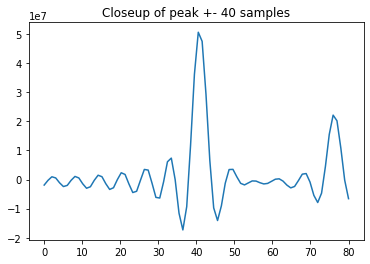

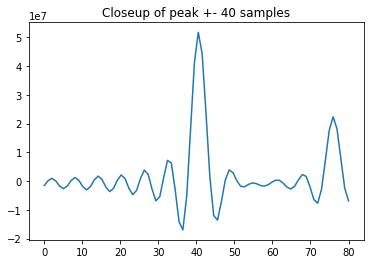

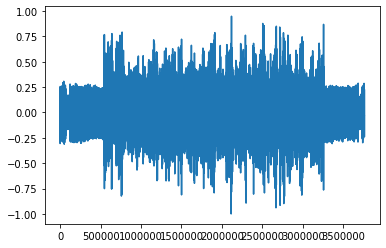

In [81]:
y_section = np.reshape(y, y.size)[0:200000]
g = np.convolve(y_section, chirp_signal[::-1], 'valid') # convoluton
i_max = np.argmax(g[:int(len(g)/2)]) # front chirp


y_section = np.reshape(y, y.size)[-200000:]
g_end = np.convolve(y_section, chirp_signal[::-1], 'valid') # convoluton
i_max_2 = np.argmax(g_end)
i_max_end = len(y) - 200000 + i_max_2

rng = 40
plot_y(g[i_max - rng:i_max + rng], f=2, title="Closeup of peak +- " + str(rng) + " samples")
plot_y(g_end[i_max_2 - rng:i_max_2 + rng], f=1, title="Closeup of peak +- " + str(rng) + " samples")


print(i_max, i_max_end)

In [69]:
# NOT SURE HOW TO DO SECOND PART OF SCHMIDL AND COX!!!!
'''afterchirp = i_max + len(chirp_signal)+101
window_length = 4096
y_window = y[afterchirp:afterchirp+window_length]

f_window = fft(y_window)

div = []
for i in range(4096):
    if i%2 == 1:
        div.append(f_window[i]/SC_fourier[i])

plot_y(np.unwrap(np.angle(div)))
plot_y(np.angle(div), f=1)
print(abs(f_window)[:10])
#plot_y(np.angle(f_window))

check_length = 2048-100
corr = []
for i in range(2048):
    p = np.array(y_window[i:i+check_length])
    p_dash = np.array(y_window[i+2048:i+2048+check_length])
    #print(p.shape, p_dash.shape)
    corr.append(np.dot(p, p_dash))
    #print(i)
    
plot_y(corr)

i_min = np.argmin(corr)
rng = 100
plot_y(corr[i_min - rng:i_min + rng], f=2, title="Closeup of peak +- " + str(rng) + " samples")'''
3

3

In [178]:
error = 1
y_confirm = y[i_max+ len(chirp_signal)+4096+100+error:]

#sliceData(time_data, timeshift, N, K, repeat)
shift = 90
CE_samples, CE_freq, remaining = sliceData(y_confirm, shift, 4096, 100, 100)

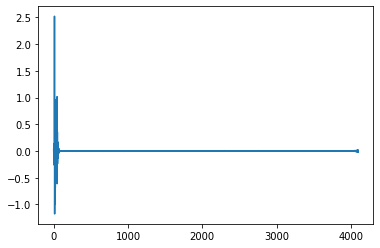

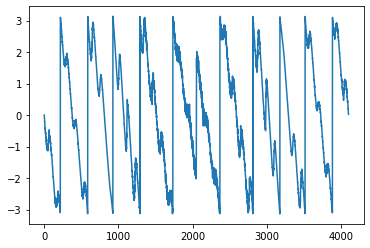

In [192]:
# getImpulseSimple(freq, known_freq, N, repeat)
impulse_simple, TF = getImpulseSimple(CE_freq, known_fourier, len(CE_freq[0]), len(CE_freq))

plot_y(impulse_simple)

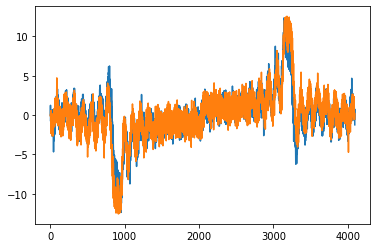

In [177]:
#getImpulseSimple(freq, known_freq, N, repeat)

TF1 = np.zeros(4096,dtype=complex)
TF100 = np.zeros(4096,dtype=complex)

for i in range(4096):
    if i == int(4096/2) or i == 0:
        TF1[i] == 0
        TF100[i] == 0
    else:
        div = (CE_freq[0][i]/known_fourier[i] )
        TF1[i] += div 
        div = (CE_freq[50][i]/known_fourier[i] )
        TF100[i] += div 

plot_y(TF1.imag)
plot_y(TF100.imag)

diff = []
for i in range(2048):
    diff.append( TF1[i] - TF100[i])
    
#plot_y(diff)

In [146]:
y_data = y_confirm[4196*100:]

In [147]:
d = len(y_data)/4096

chunks = []
for i in range(math.floor(d)):
    chunks.append(y_data[i*4096:(i+1)*4096])

In [189]:
binary = []
chunk0 = y_data[shift+10:4096+shift+10]
freq = TF[1:2048]
fft_data = fft(chunk0)[1:2048]

div = np.divide(fft_data, freq)
for j in range(len(div)):
    #div = fft_data[j]/TF[j+1]

    bit0 = 0
    bit1 = 0

    if div[j].real < 0:
        bit1 = 1
    if div[j].imag < 0:
        bit0 = 1

    binary.append(bit0)
    binary.append(bit1)

bin_single_sting = ""
for i in range(len(binary)):
    bin_single_sting += str(binary[i])

In [190]:
# Find information about the file name and the byte length of the file
file_seperation = []
count = 0
for i in range(math.floor(len(binary)/8)):
    byte = binary[i*8:(i+1)*8]
    zero = True
    for bit in byte:
        if bit == 1:
            zero = False
            
    if zero:
        #print(byte, "zero")
        file_seperation.append(i*8)
            
        count += 1
    
    if count == 2:
        break
        
print(file_seperation)
# Extract file name and length of the file
Filename= str_to_bytearray(bin_single_sting[0:file_seperation[0]]).decode("utf-8", "replace")
Length = int(str_to_bytearray(bin_single_sting[file_seperation[0]+8:file_seperation[1]]).decode("utf-8", "replace"))

extra_bits = len(binary) - file_seperation[1] - 8 - Length*8

raw_file = bin_single_sting[file_seperation[1] + 8 : -1*extra_bits]

print(Filename, Length, extra_bits)

[80, 744]


ValueError: invalid literal for int() with base 10: '375,`f`�S��\x18R_U�������EwUu�nUUw��]�\x7fA��������������Y���8�\x1d�h�S�\x1e���\x19����3�C*p�\x03��'

In [191]:
str_to_bytearray(bin_single_sting[:3000]).decode("utf-8", "replace")

'd1d76t.wA�\x00375,`f`�S��\x18R_U�������EwUu�nUUw��]�\x7fA��������������Y���8�\x1d�h�S�\x1e���\x19����3�C*p�\x03��\x00�\x00\x11\x01\x14\x01�\x02E\x00:\x00�\x00;\x00��v\x00/\x00ؿ����rU��\x00�\x1f�\x1e�Ń1�C���\x1b�8����\x08m\x08< 8\x00K\x00�\x02��v\x00+�<\x00+EW\x00{Q�\x15�U]U_UmUIU�UfU�u\\U�WOW�(S�\x00\x00��+\x005\x00-\x00 \x00\x05\x00I\x00V\x00h\x00j\x00H\x00*Ef\x15UU�U�U�UmU{U#����U�U�w\x02���\x00\x02������\r\x00\x18\x00"\x00��������5*_\x14@\x10\x16\x15^U��_U��}UzUpU�UT�\n\ny7<�x]�w���������\x05\x00������Į��3�\x08*P՞�\x1f�7�b������*���h\x08�&\x03�!9�(�\x19 ,\x04\t\x00\x08'